# Parser for HWDDDA Project

In [1]:
#! pip install pandas
#! pip install matplotlib
#! pip install vectormath
#! pip install pyvista
#! pip install vtk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectormath as vmath
import pyvista as pv
from datetime import datetime, timedelta

import panel
panel.extension("vtk")
pv.set_plot_theme("document")

skiprows = 0 #used for ProcessData() to slide the start of the window

Read the datafile and stick it in a data frame. Fixup a bunch of the data in the process (i.e. parse dates, calculate time per sample to interpolate the repeated timestamp blocks)

The data file starts with a calibration block (not currently parsing that calibration, just skipping it). TODO: need to apply proper calibration to the data

Since we have a bunch of data files, wrap this parsing into a function so we can cleanly call it once for each file.

Use either the stoprow or the rowcount. Stoprow takes precedence. This is meant to limit the loaded data, but still provide a workable dataset that can be diced up later and re-processed without reloading the whole file.

In [3]:
def LoadData(fname, startrow=0, stoprow=999999999999, rowcount=-1):
    filename = "../../data/preliminary/" + fname
    #f = lambda s: pd.to_datetime(s, format="%m/%d/%y-%H:%M:%S:%f") #handle the custom date format
    def f(s): #need to left pad the milliseconds
        if(len(s) != 21): #the string length (should) only vary by the last 3 characters, i.e. ms
            s = s[0:s.rfind(":")] + ":" + s[s.rfind(":")+1:].zfill(3)
        return pd.to_datetime(s, format="%m/%d/%y-%H:%M:%S:%f", errors='ignore')

    
    if rowcount > 0:
        stoprow = startrow + rowcount
    
    
    #TODO: need to use readable column names to avoid confusion
    headers = ["dt", "Sch", "Ch0", "Ch1", "Ch2", "Ch3", "Ch4", "Ch5", "Ch6", "Ch7", "Ch8"]#, "empty"]
    df = pd.read_csv(filename, 
                     header=None, names=headers, 
                     index_col=False, #deal with trailing comma shifting the columns
                     skiprows=12+startrow,  #skip the calibration block for now
                     nrows=stoprow-startrow,
                     parse_dates=["dt"],
                     date_parser=f,
                     low_memory=False)
    
    
    #add a counter column for easy plotting. Keep the index so we can narrow the plots (i.e. use the x value to remap this function's start/stop row).
    df.insert(loc=0, column="cnt", value=np.arange(start=startrow, stop=len(df)+startrow))
    
    #add a column for the millisecond of the given sample
    #NOTE: this is not backwards validated... just the time from beginning to the end
    #TODO: this is slightly flawed in that the arbitrary start/stop daetime isnt the actual timestamp of that specific record (need to back up to the first of the repeated timestamp value)
    totalms = (df["dt"][len(df)-1] - df["dt"][0]).total_seconds() * 1000
    if np.isnan(totalms):
        print("ERROR: couldnt determine total milliseconds. Check input file.")
    else:
        mspersample = totalms / len(df)
        #print(mspersample)
        df.insert(loc=1, column="totalms", value=np.arange(start=0, stop=totalms, step=mspersample))
    
    
    #TODO: iterate to fixup the time per sample calculated. This is sloppy and slow, but should be functional
    mspersample = []
    fixedts = []
    basets = np.nan #holds the base timestamp, i.e. the first timestamp in a block
    nextts = np.nan #holds the next timestamp, i.e. the value of the next block
    countts = 0 #holds the number of repeated timestamps for the current block
    countcurr = 0
    for index, row in df.iterrows():
        #print(index, "-------")
        if basets != row["dt"]: #the current timestamp changed, so we need to update a bunch of things for this block
            basets = row["dt"] #update the current block's NEW timestamp
            countts = 0
            countcurr = 0
            #find the next timestamp and count the values
            for x in range(20): #limit to 20 to find the next new timestamp
                dfindex = index + x
                if dfindex >= len(df): break #fell off the end
                
                if basets == df["dt"][dfindex]: #found a repeat
                    countts += 1 #count the repeated values (could also set to x)
                else: #found a new timestamp, so we're done
                    nextts = df["dt"][dfindex]
                    break
        else: #current timestamp didnt change, so just use the previously calculated values
            countcurr += 1
        msval = ((nextts - basets).total_seconds() * 1000) / countts
        mspersample.append(msval)
        fixedts.append(basets + timedelta(microseconds=(msval * 1000 * countcurr)))
        
    df.insert(loc=2, column="mspersample", value=mspersample)
    df.insert(loc=3, column="fixedtsfixedts", value=fixedts)
    
    print("# of rows:", len(df))
    #print(df)
    #print(df.head(5))
    
    return(df)

In [4]:
def ProcessData(tmpdf, calib, skiprows=0, rowcount=99999999):
    print("skipping rows:", skiprows)
    dfcalib = df[skiprows:skiprows+rowcount].copy() #because we are going to dice up the dataframe, and we will likely want to re-process it
    
    #calibrate the values
    dfcalib["AccelCalibGCh3"] =  (df["Ch3"]-calib["AccelZeroCh3"])/calib["AccelGainCh3"]
    dfcalib["AccelCalibGCh4"] =  (df["Ch4"]-calib["AccelZeroCh4"])/calib["AccelGainCh4"]
    dfcalib["AccelCalibGCh5"] =  (df["Ch5"]-calib["AccelZeroCh5"])/calib["AccelGainCh5"]
    
    #subtract off the mean to give zeroed calibrated G's with gravity removed
    dfcalib["AccelZeroedGCh3"] = dfcalib["AccelCalibGCh3"] - dfcalib["AccelCalibGCh3"].mean()
    dfcalib["AccelZeroedGCh4"] = dfcalib["AccelCalibGCh4"] - dfcalib["AccelCalibGCh4"].mean()
    dfcalib["AccelZeroedGCh5"] = dfcalib["AccelCalibGCh5"] - dfcalib["AccelCalibGCh5"].mean()
    
    #TODO: use the milliseconds per sample to calculate the actual velocity
    
    dfcalib["VelCh3"] = ((dfcalib["AccelZeroedGCh3"]+dfcalib["AccelZeroedGCh3"].shift(1))/2 * (dfcalib["mspersample"]/1000) * 386.0886).cumsum()
    dfcalib["VelCh4"] = ((dfcalib["AccelZeroedGCh4"]+dfcalib["AccelZeroedGCh4"].shift(1))/2 * (dfcalib["mspersample"]/1000) * 386.0886).cumsum()
    dfcalib["VelCh5"] = ((dfcalib["AccelZeroedGCh5"]+dfcalib["AccelZeroedGCh5"].shift(1))/2 * (dfcalib["mspersample"]/1000) * 386.0886).cumsum()

    dfcalib["PosDeltaCh3"] = dfcalib["VelCh3"] * dfcalib["mspersample"]/1000
    dfcalib["PosDeltaCh4"] = dfcalib["VelCh4"] * dfcalib["mspersample"]/1000
    dfcalib["PosDeltaCh5"] = dfcalib["VelCh5"] * dfcalib["mspersample"]/1000
    dfcalib["PosCh3"] = dfcalib["PosDeltaCh3"].cumsum()
    dfcalib["PosCh4"] = dfcalib["PosDeltaCh4"].cumsum()
    dfcalib["PosCh5"] = dfcalib["PosDeltaCh5"].cumsum()
    
    
    return(dfcalib)

In [5]:
def PlotDataRaw(_df):
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGCh5", title="Acc Ch5", color="green")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGCh3", title="Acc Ch3", color="red")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="AccelZeroedGCh4", title="Acc Ch4", color="blue")
    plt.show()

In [6]:
def PlotDataProcessed(_df):
    _df.plot(kind="scatter", x="cnt", y="VelCh5", title="Velocity Ch5", color="green")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosCh5", title="Position Ch5", color="green")
    plt.show()
    
    _df.plot(kind="scatter", x="cnt", y="VelCh3", title="Velocity Ch3", color="red")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosCh3", title="Position Ch3", color="red")
    plt.show()    
    
    _df.plot(kind="scatter", x="cnt", y="VelCh4", title="Velocity Ch4", color="blue")
    plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosCh4", title="Position Ch4", color="blue")
    plt.show()    

Only run one of these, or just make sure the last one is the one you want to use.

Try and get the start/stop row index to cover legitimate data (i.e. exclude bad startup and shutdown data if present).

In [7]:
#df = LoadData("file_43_calibrated_20180516102829.csv") #this one has a bunch of empty values

In [8]:
df = LoadData("File_18_1002_Calibrated_20190510135452.csv", 0, 100)

# of rows: 100


In [9]:
df = LoadData("Thorman B-3/File_35_1002_Calibrated_20190801103404.csv", 8723, rowcount=5000)
#print(df)

calibration = {
    "AccelZeroCh3": 17288.88, #I'm not sure these are correct... shouldnt it be closer to zero? maybe its an unsigned value?
    "AccelZeroCh4": 17217.23,
    "AccelZeroCh5": 16897.29,
    
    "AccelGainCh3": 7314.35, 
    "AccelGainCh4": 7467.77, 
    "AccelGainCh5": 7488.96
}

# of rows: 5000


skipping rows: 642


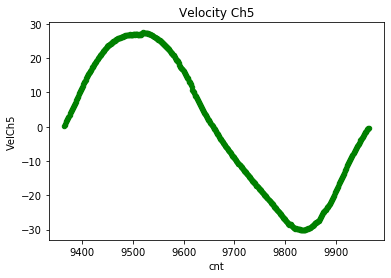

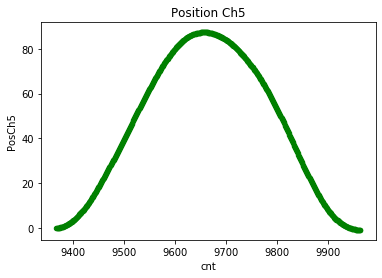

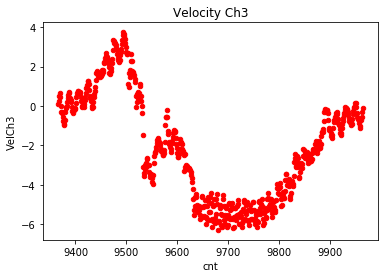

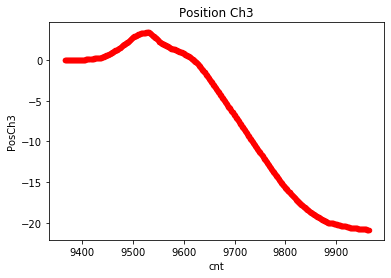

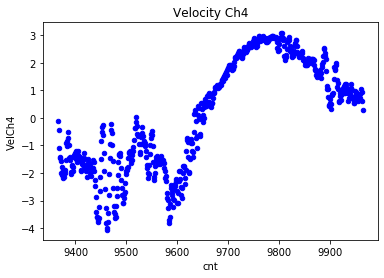

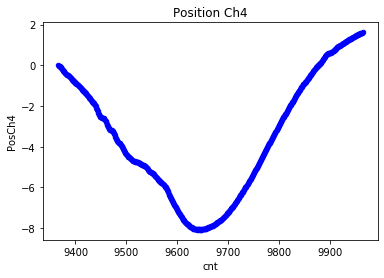

In [10]:
#in progress... calibrate & zero, then double integrate. Need to incorporate the time in the integration.

skiprows = 642
#skiprows += 10
#skiprows -= 5

dfprocessed = ProcessData(df, calibration, skiprows=skiprows, rowcount=600)
PlotDataProcessed(dfprocessed)

In [11]:
df.describe() #get some stats

cnt       totalms  mspersample     Sch     Ch0           Ch1  \
count   5000.000000   5000.000000  5000.000000  5000.0  5000.0   5000.000000   
mean   11222.500000  41628.672600    16.654800     5.0   960.0  16356.087600   
std     1443.520003  24041.536951     0.667328     0.0     0.0     17.624382   
min     8723.000000      0.000000     0.000000     5.0   960.0  16328.000000   
25%     9972.750000  20814.336300    16.692308     5.0   960.0  16342.000000   
50%    11222.500000  41628.672600    16.692308     5.0   960.0  16353.000000   
75%    12472.250000  62443.008900    16.692308     5.0   960.0  16369.000000   
max    13722.000000  83257.345200    16.692308     5.0   960.0  16392.000000   

               Ch2           Ch3           Ch4           Ch5          Ch6  \
count  5000.000000   5000.000000   5000.000000   5000.000000  5000.000000   
mean   8238.243342  17911.819400  17948.416400  24401.806000  6730.072800   
std       2.361360    414.465462    355.175987    238.347685     6.208608   
min    8232.640000  13894.000000  14283.000000  22480.000000  6710.000000   
25%    8236.230000  17691.000000  17796.750000  24220.000000  6726.000000   
50%    8238.790000  17916.000000  17965.000000  24367.500000  6730.000000   
75%    8240.330000  18148.000000  18113.000000  24566.250000  6734.000000   
max    8240.840000  20994.000000  19996.000000  25963.000000  6753.000000   

                Ch7          Ch8  
count   5000.000000  5000.000000  
mean   12957.438000  8788.137400  
std        8.019116    20.023654  
min    12936.000000  8756.000000  
25%    12952.000000  8774.000000  
50%    12957.000000  8780.000000  
75%    12962.000000  8797.000000  
max    12988.000000  8843.000000

Now we can plot the data. matplotlib is a bit more interactive when run locally, but this should be good enough for now.
Just plot the individual components to get an overview.

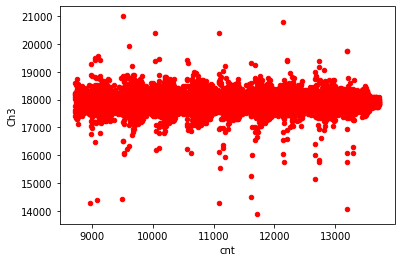

In [12]:
df.plot(kind='scatter',x='cnt',y='Ch3',color='red')
plt.show()

Which channel is this?

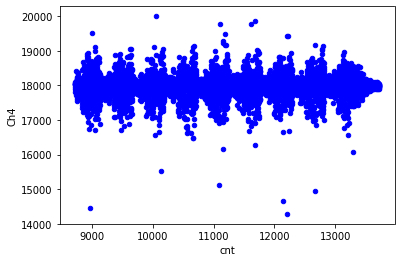

In [13]:
df.plot(kind='scatter',x='cnt',y='Ch4',color='blue')
plt.show()

I think this is Z

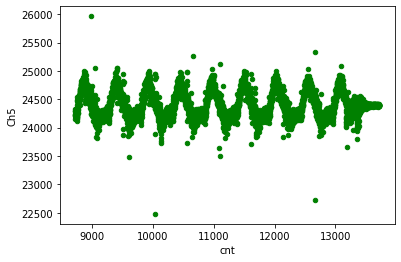

In [14]:
df.plot(kind='scatter',x='cnt',y='Ch5',color='green')
plt.show()

Lets get the gravity vector now. This should also be the direction of tool travel. Ideally, the samples that are not part of normal motion should have been eliminated above, and we should have enough samples to wash out partial strokes at the beginning/end.

In [15]:
gravityv = vmath.Vector3(df["Ch3"].mean(), df["Ch4"].mean(), df["Ch5"].mean())
print("Gravity vector:", gravityv)

#not sure if these next few lines are needed....

#I suck at python, but this should be an array of x,y,z vectors
arrxyz = np.reshape((np.array(df["Ch3"]), np.array(df["Ch4"]), np.array(df["Ch5"])), (3, -1)).transpose()


#load them into a Vector3Array to operate on
v_array = vmath.Vector3Array(arrxyz)

Gravity vector: [17911.8194 17948.4164 24401.806 ]


Give a 3D view of that gravity vector... should roughly indicate the orientation of the tool.

In [16]:
pg = pv.Plotter()
pg.set_background("gray")
veczero = np.array([0., 0., 0.])

#TODO: probably want to orient these so direction of travel is up/down on this plot
vecgrav = np.array([df["Ch3"].mean(), df["Ch4"].mean(), df["Ch5"].mean()])
gravline = np.stack((veczero, vecgrav))
_ = pg.add_lines(gravline, color="red")


#because I cant figure out how to plot the proper grid in pyvista. This is a bit hacky.
vertline = np.stack((veczero, np.array([0., 32000., 0.])))
_ = pg.add_lines(vertline, color="blue")


horiline = np.stack((veczero, np.array([32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([-32000., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((veczero, np.array([0., 0., 32000.])))
_ = pg.add_lines(horiline, color="green")

horiline = np.stack((veczero, np.array([0., 0., -32000.])))
_ = pg.add_lines(horiline, color="green")



_ = pg.add_axes(interactive=True, color="blue") #notebook doesnt render helper
_ = pg.show_bounds(grid="front", location="outer", all_edges=True, color="red")
pg.show_grid() #not working?

In [17]:
pg.plot()

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

## TODO: should apply calibration to the raw sample data

Just plot all acceleration samples. Not too helpful at this point.

In [18]:
p = pv.Plotter()
p.set_background("gray")

verts = np.column_stack((df["Ch3"], df["Ch4"], df["Ch5"]))
_ = p.add_points(verts, color="red")
_ = p.add_axes()

In [19]:
p.show()

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

In [20]:
pc = pv.PolyData(verts)
pc.plot(point_size=1, show_grid=True, color='red')

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

In [21]:
print("test")

test
